You will need to use the QDK conda environment. If you do not have the environment, execute the following cell to create a file called environment.yml that can be used to create the QDK conda environment.

In [1]:
%%writefile environment.yml
name: qdk
channels:
  - conda-forge
  - microsoft
dependencies:
  - python=3.9
  - qsharp
  - networkx
  - rdkit
  - pip
  - jupyter
  - pytest
  - ipywidgets
  - ruamel.yaml
  - varname
  - pip:
    - basis_set_exchange
    - jupyter_jsmol

Overwriting environment.yml


In [2]:
import numpy as np


PauliI  = np.array([[ 1, 0],
               [ 0, 1]])
PauliX = np.array([[ 0, 1],
               [ 1, 0]])
PauliY = np.array([[ 0,-1j],
               [1j, 0]])
PauliZ = np.array([[ 1, 0],
               [ 0,-1]])

from functools import reduce

This is where you set the input/yaml file name. Uncomment the last line to see the encoded data if you wish.

In [3]:
from qdk.chemistry.broombridge import load_and_encode
encoded_data = load_and_encode("LiH.yaml")
# encoded_data

Preparing Q# environment...


Adding package microsoft.quantum.chemistry.jupyter.

Write the file for the QPE calculation.

In [4]:
%%writefile RPE.qs
namespace Microsoft.Quantum.Chemistry.RPE {
    open Microsoft.Quantum.Core;
    open Microsoft.Quantum.Intrinsic;
    open Microsoft.Quantum.Canon;
    open Microsoft.Quantum.Chemistry;
    open Microsoft.Quantum.Chemistry.JordanWigner;  
    open Microsoft.Quantum.Simulation;
    open Microsoft.Quantum.Characterization;
    open Microsoft.Quantum.Convert;
    open Microsoft.Quantum.Math;

    operation GetEnergyRPE (
        JWEncodedData: JordanWignerEncodingData,
        nBitsPrecision : Int, 
        trotterStepSize : Double, 
        trotterOrder : Int
    ) : (Double, Double) {

        Message($"JWEncodedData:\n{JWEncodedData}");
        let (nSpinOrbitals, fermionTermData, inputState, energyOffset) = JWEncodedData!;
        Message($"inputState:\n{inputState}");
        let statePrep = PrepareTrialState(inputState, _);
        Message($"statePrep:\n{statePrep}");
        let (nQubits, (rescaleFactor, oracle)) = TrotterStepOracle(JWEncodedData, trotterStepSize, trotterOrder);
        Message($"nQubits: {nQubits}, rescaleFactor: {rescaleFactor}, oracle: {oracle}");
        let phaseEstAlgorithm = RobustPhaseEstimation(nBitsPrecision, _, _);
        Message($"phaseEstAlgorithm:\n{phaseEstAlgorithm}");
        let estPhase = EstimateEnergy(nQubits, statePrep, oracle, phaseEstAlgorithm);
        let estEnergy = estPhase * rescaleFactor + energyOffset;
        Message($"estPhase: {estPhase}, rescaleFactor: {rescaleFactor}, energyOffset: {energyOffset}");

        return (estPhase, estEnergy);
    }
}

Overwriting RPE.qs


In [5]:
import qsharp
qsharp.reload()
from Microsoft.Quantum.Chemistry.RPE import GetEnergyRPE

Reloading workspace.

Finished Iteration  5
[-0.378210093917449, -0.378210093917449, -0.39269908169872414, -0.36815538909255385, -0.3581006842676588]
[-7.917968082325052, -7.917968082325052, -8.062857960137803, -7.817421034076101, -7.716873985827149]


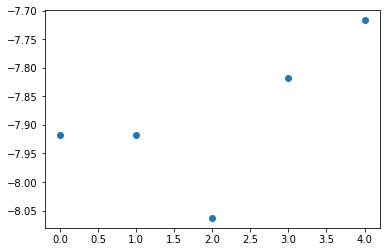

CPU times: user 2.2 s, sys: 509 ms, total: 2.71 s
Wall time: 4min 4s


In [6]:
%%time
import matplotlib.pyplot as plt
from IPython.display import clear_output
Energies = []
Phases = []

nsamples = 5
for i in range(nsamples):
    Data = GetEnergyRPE.simulate(JWEncodedData=encoded_data, 
                                          nBitsPrecision=6, #11 gives a std. dev ~ 4mH
                                          trotterStepSize=0.1,
                                          trotterOrder=1)
    
    Energies.append(Data[1])
    Phases.append(Data[0])
    clear_output(wait=True)
    print("Finished Iteration ",i+1)
    print(Phases)
    print(Energies)
    plt.scatter(range(len(Energies)),Energies)
    plt.show()

Std. Dev. goes as 1/2^{bits of precision} but time goes as 2^{bits of precision}